<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Otimiza%C3%A7%C3%A3o_Ag_pol%C3%ADtica_de_manuten%C3%A7%C3%A3o_preventiva_imperfeita_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [570]:
%%capture
pip install geneticalgorithm

In [571]:
%%capture
pip install memory-profiler

In [572]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv
import math
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import differential_evolution
from memory_profiler import profile
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import locale

In [573]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [574]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [575]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [576]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [577]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 17000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = 'ag'

# Configuraçaõ dos cerarios utulidados para os testes: primeiro_cenario, segundo_cenario, terceiro_cenario, quarto_cenario
CENARIO = 'primeiro_cenario'

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/Resultados_{CENARIO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_{CENARIO}'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'
NOME_ARQUIVO_PARAMETROS = 'parametros'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO_TESTE = f'{CENARIO}'

In [578]:
print(LINK_ARQUIVO_PRINCIPAL)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/Resultados_primeiro_cenario/


In [579]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha $\it{u(t)}$")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [580]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [581]:
# efine a função de melhoria Linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j]*theta)
        fator.append(linha)

    return fator

In [582]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [583]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j]**theta)
        fator.append(linha)

    return fator

In [584]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [585]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [586]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.2: 2000, 0.4: 4000, 0.5: 9000, 0.9: 12000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.1 or si > 1.0 else np.interp(si, [0.2, 0.4, 0.5, 0.9], [2000, 4000, 9000, 12000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US
17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US 2.000 e US
3.000, respectivamente e MC fixa em US$15.000 texto em itálico

In [587]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/{CENARIO_TESTE}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0


* t: Representa os tempos de falha.
* k: Indica o índice do sistema.
* c: Representa o número de ciclos de manutenção.
* n: Indica o número de falhas em cada ciclo de manutenção preventiva.
* s: Representa a severidade das manutenções preventivas em cada sistema.
* T: Indica os tempos das manutenções preventivas.

In [588]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [589]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [590]:
# Ajusta o modelo com base nos dados lidos
def adjust_model():
    global model_adjusted
    model_adjusted = True

    varbound = np.array([[100, 150], [3, 5], [0, 1]])

    algorithm_param = {
        'max_num_iteration': 50,
        'population_size': 100,
        'mutation_probability': 0.05,
        'elit_ratio': 0.01,
        'crossover_probability': 0.75,
        'parents_portion': 0.3,
        'crossover_type': 'two_point',
        'max_iteration_without_improv': None
    }

    model = ga(
        function=objective,
        dimension=3,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param,
        convergence_curve=False,
        progress_bar=False
    )

    # Registre o tempo de início de convergência para a primeira etapa
    start_time_first_stage = time.time()

    model.run()


    # Registre o tempo de término
    end_time_first_stage = time.time()

    # Calcule o tempo total de convergência
    convergence_time_first_stage = end_time_first_stage - start_time_first_stage

    res = model.best_variable

    lamb = res[0]
    beta = res[1]
    theta = res[2]

    return lamb, beta, theta, convergence_time_first_stage

In [591]:
# Variáveis Globais
model_adjusted = False

In [592]:
# Ajusta o modelo
lamb, beta, theta, convergence_time_first_stage = adjust_model()
print(f'lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

 The best solution found:
 [149.33117004   3.54962403   0.85589017]

 Objective function:
 -2.0897832679053216e-23
lamb: 149.3311700370001
beta: 3.549624031293432
theta: 0.8558901716039499

Tempo de Convergência para a primeira etapa: 2.30898118019104 segundos


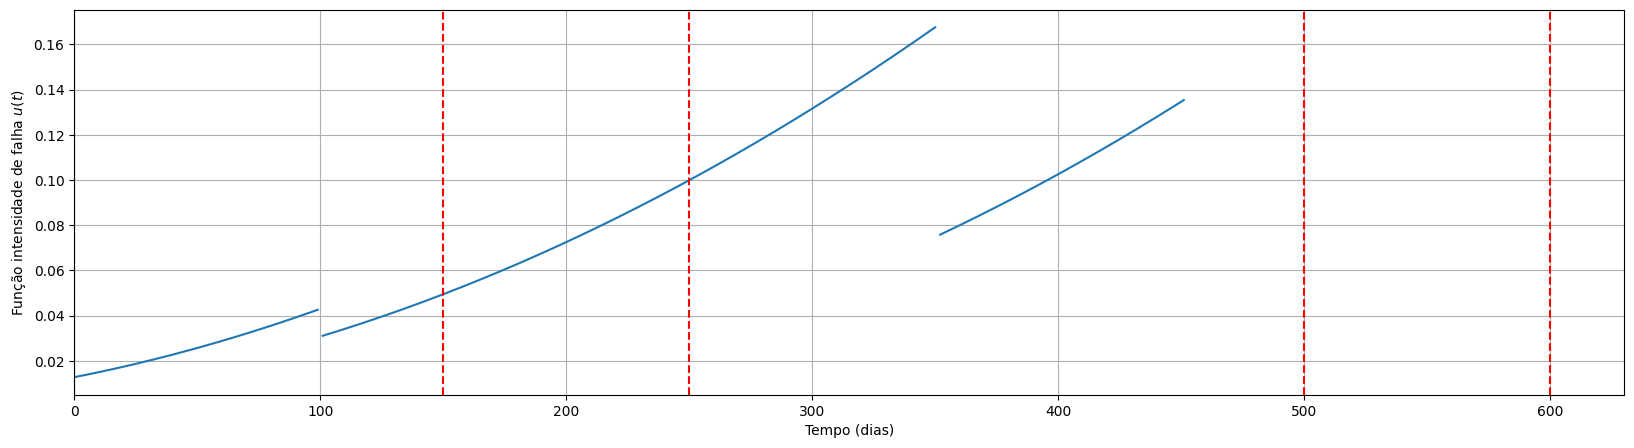

Fator ajuste:  [0.21460965150428413, 0.26063829953822626, 0.4193124564099424, 0.1137774836443638]


In [593]:
lamb = 148.0738165527265
beta = 2.9738148965776925
theta = 0.603936063904796


solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [594]:
# Nome do arquivo CSV para salvar os resultados dos parametros
nome_arquivo_parametros = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PARAMETROS}.csv'
print(nome_arquivo_parametros)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/Resultados_primeiro_cenario/parametros.csv


In [595]:
# # Gravar os valores de Lambda, Beta e Theta em um arquivo separado
# melhores_parametros = []

# try:
#     with open(nome_arquivo_parametros, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_parametros.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução


# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_parametros), lamb, beta, theta, convergence_time_first_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo_parametros, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [596]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo_parametros, sep=",")
resultado.head(10)

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
0,0,149.208584,2.936097,0.499454,1.489012
1,1,147.034714,2.993123,0.654387,1.662905
2,2,147.487236,2.994573,0.653252,1.586113
3,3,149.515510,2.975848,0.576775,1.533569
4,4,149.438587,2.991677,0.536631,1.521361
5,5,148.599075,2.953805,0.580221,1.517371
6,6,148.571839,2.984237,0.583568,1.732526
7,7,148.547688,2.964529,0.646544,1.552353
8,8,143.945652,2.955441,0.740724,1.977993
9,9,148.389280,2.988819,0.567804,1.511202


In [597]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
count,10.00000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,148.073817,2.973815,0.603936,1.608440
std,3.02765,1.651340,0.020296,0.069897,0.150473
min,0.00000,143.945652,2.936097,0.499454,1.489012
25%,2.25000,147.712747,2.957713,0.570047,1.518368
50%,4.50000,148.559763,2.980042,0.581894,1.542961
75%,6.75000,149.056207,2.990963,0.651575,1.643707
max,9.00000,149.515510,2.994573,0.740724,1.977993


In [598]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']

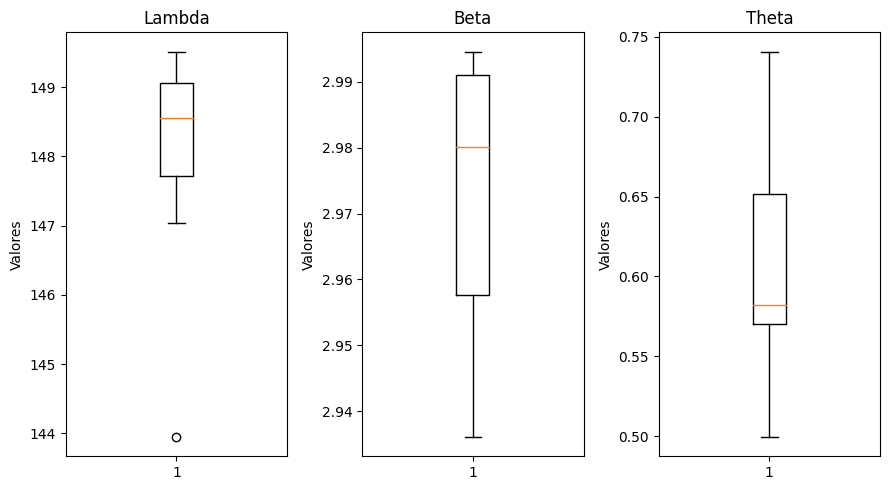

In [599]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

# Etapa 2: Otimização

In [600]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [601]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]

def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.2, 3:0.4, 5:0.5, 7:0.9}

    results = [] # Lista para armazenar os resultados das funções objetivo

    global s
    T = [0]
    s_row = []
    cont = 0

    for number in x:
        modulo = int(number) % 2
        if modulo == 1:
            inteiro = int(number)
            s_row.append(dict_severidades[inteiro])  # Severidade
            frac = number - inteiro  # Tempo
            t = (cont + frac) * 30
            T.append(int(t))
        cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
    #
    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))
    #
    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)
    #
    # Retorna o custo
    return np.array(results)

Aplica AG para determinar tempos e severidades



Número de ciclos de manutenção: 10
Tempos para manutenções preventivas: [0, 146, 217, 242, 442, 452, 514, 624, 659, 663, 719]
Severidade para cada subsistema: [0.4, 0.2, 0.2, 0.5, 0.2, 0.5, 0.9, 0.4, 0.4, 0.2]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.21460965150428413, 0.1137774836443638, 0.1137774836443638, 0.26063829953822626, 0.1137774836443638, 0.26063829953822626, 0.4193124564099424, 0.21460965150428413, 0.21460965150428413, 0.1137774836443638]
Media de falhas:  [0, 0.958923917609181, 2.74828075497816, 3.511470987201006, 21.84892556421637, 23.253811901425816, 30.667730626508217, 56.184813854204904, 63.31672239039975, 63.84549602250769, 78.78118238644025, 81.94346000230786]
Custo =  25009.294756867315


Número de ciclos de manutenção: 15
Tempos para manutenções preventivas: [0, 48, 83, 118, 125, 166, 214, 255, 287, 325, 390, 437, 494, 528, 606, 634]
Severidade para cada subsistema: [0.5, 0.4, 0.5, 0.9, 0.9, 0.2, 0.4, 0.9, 0.4, 0.5, 0.9, 0.9, 0.9, 0.2, 0.2]
Número de Si

<ipython-input-601-a728fc4c2151>:81: RuntimeWarning: divide by zero encountered in scalar divide
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))




Número de ciclos de manutenção: 16
Tempos para manutenções preventivas: [0, 22, 87, 110, 127, 213, 251, 365, 401, 436, 472, 495, 517, 550, 591, 625, 635]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.9, 0.9, 0.9, 0.4, 0.5, 0.2, 0.2, 0.9, 0.2, 0.9, 0.9, 0.5]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.1137774836443638, 0.4193124564099424, 0.4193124564099424, 0.4193124564099424, 0.21460965150428413, 0.26063829953822626, 0.1137774836443638, 0.1137774836443638, 0.4193124564099424, 0.1137774836443638, 0.4193124564099424, 0.4193124564099424, 0.26063829953822626]
Media de falhas:  [0, 0.003447592702284813, 0.18960798071786808, 0.35813347120039574, 0.5349445848356162, 2.48507575599431, 3.978280767228993, 8.343468992803912, 10.07049250776686, 12.055531943659457, 16.243991960010177, 18.91939885726878, 22.87816741347814, 29.48677589283056, 33.73655697965508, 42.542398740264204, 43.75323082863994, 58.48781397823216]
Cu

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


A saída de streaming foi truncada nas últimas 5000 linhas.
Severidade para cada subsistema: [0.4, 0.4, 0.5]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.21460965150428413, 0.21460965150428413, 0.26063829953822626]
Media de falhas:  [0, 0.020399957114324636, 0.5340595885392003, 1.0998421736829367, 99.34326161997284]
Custo =  3287.1459535920403


Número de ciclos de manutenção: 2
Tempos para manutenções preventivas: [0, 37, 212]
Severidade para cada subsistema: [0.2, 0.5]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.1137774836443638, 0.26063829953822626]
Media de falhas:  [0, 0.016178603622639683, 2.7438536963484466, 104.70497030626817]
Custo =  3315.75874522505


Número de ciclos de manutenção: 3
Tempos para manutenções preventivas: [0, 34, 76, 377]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.1137774836443638, 0.26063829953822626, 0.26063829953822626, 0.26063829953822626]
Media de falhas:  [0, 0.012581551635142395, 0.12158987546228933, 

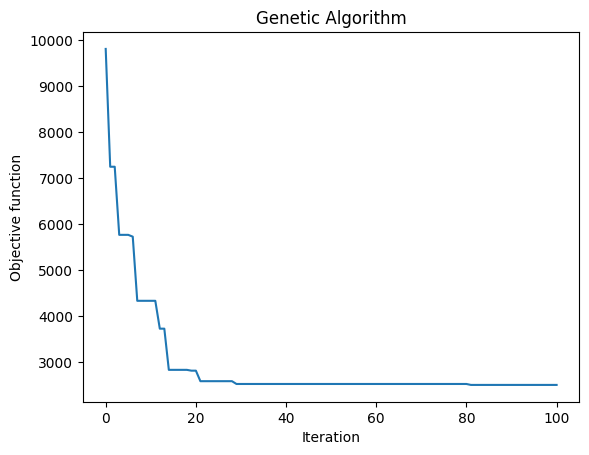

In [602]:
# Otimização da política de manutenção com AG
dimension = 24
varbound = np.array([[0, 8]] * 24)

algorithm_param_ = {
    'max_num_iteration': 100,\
    'population_size': 100,\
    'mutation_probability': 0.05,\
    'elit_ratio': 0.01,\
    'crossover_probability': 0.75,\
    'parents_portion': 0.3,\
    'crossover_type': 'two_point',\
    'max_iteration_without_improv': None
}

model_=ga(
    function = objective_st,
    dimension = dimension,
    variable_type = 'real',
    variable_boundaries = varbound,
    algorithm_parameters = algorithm_param_
)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

model_.run()

# Registre o tempo de término
end_time_second_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

In [603]:
convergence = model_.report # número total de interações
solution = model_.output_dict['function'] # Melhor Custo
print(convergence)
print(solution)

[9809.159593812965, 7249.090538471386, 7249.090538471386, 5769.109970301275, 5769.109970301275, 5769.109970301275, 5729.514493281775, 4336.01353265631, 4336.01353265631, 4336.01353265631, 4336.01353265631, 4336.01353265631, 3730.561483883965, 3730.561483883965, 2835.80789146297, 2835.80789146297, 2835.80789146297, 2835.80789146297, 2835.80789146297, 2818.0331030791913, 2818.0331030791913, 2589.5151323213627, 2589.5151323213627, 2589.5151323213627, 2589.5151323213627, 2589.5151323213627, 2589.5151323213627, 2589.5151323213627, 2589.5151323213627, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268265427, 2528.796268

In [604]:
# Retorna o número de interações necessárias para chegar ao melhor custo.
def numero_interacoes(convergence):
  for i, custo in enumerate(convergence):
    if custo == min(convergence):
      return i + 1

numero_interacoes = numero_interacoes(convergence)
print(numero_interacoes)

82


In [605]:
melhorCusto = format_currency(model_.output_dict['function'])
print(melhorCusto)

R$ 2.508,26


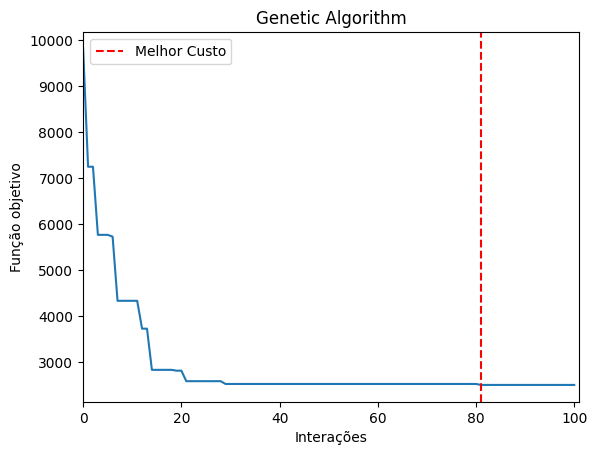


Cenário: primeiro_cenario
Número total de iterações: 100
Tamanho da população: 100
Número de Dimensões: 24
Melhor Custo: R$ 2.508,26
Número de Iterações até o Melhor Custo: 82
Tempo de Convergência para a segunda etapa: 74.24892067909241 segundos


In [606]:
# Plotando a curva de convergência
plt.figure()
plt.plot(convergence)

# Localizando o índice da melhor interação
index_melhor_custo = convergence.index(min(convergence))

# Plotando a linha vertical
plt.axvline(index_melhor_custo, color='red', linestyle='--', label='Melhor Custo')

plt.xlabel('Interações')
plt.xlim(0, len(convergence))
plt.ylabel('Função objetivo')
plt.title('Genetic Algorithm')
plt.legend()
plt.show()

print("")
print('Cenário:', CENARIO)
print("Número total de iterações:", algorithm_param_['max_num_iteration'])
print("Tamanho da população:", algorithm_param_['population_size'])
print("Número de Dimensões:", dimension)
print("Melhor Custo:", melhorCusto)
print("Número de Iterações até o Melhor Custo:", numero_interacoes)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

In [607]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'
print(nome_arquivo)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/Resultados_primeiro_cenario/melhor_custo_ag_primeiro_cenario.csv


In [608]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(melhorCusto)

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), melhorCusto, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [609]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 2.501,76",87.202981,NaN
1,2,"R$ 2.502,67",89.537100,NaN
2,3,"R$ 2.502,19",86.290811,NaN
3,4,"R$ 2.510,97",88.560069,NaN
4,5,"R$ 2.510,15",90.722988,NaN
5,6,"R$ 2.504,93",88.767164,NaN
6,7,"R$ 2.524,75",90.204487,NaN
7,8,"R$ 2.502,67",91.636558,NaN
8,9,"R$ 2.501,76",88.310763,NaN
9,10,"R$ 2.502,67",87.371826,NaN


In [610]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       11 non-null     int64  
 1   Melhor_Custo                11 non-null     object 
 2   Convergencia_Segunda_Etapa  11 non-null     float64
 3   Ciclos_MP                   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 480.0+ bytes


In [611]:
resultado.describe()

,Index,Convergencia_Segunda_Etapa,Ciclos_MP
count,11.000000,11.000000,0.0
mean,6.000000,87.145886,NaN
std,3.316625,5.905819,NaN
min,1.000000,70.000000,NaN
25%,3.500000,87.287403,NaN
50%,6.000000,88.560069,NaN
75%,8.500000,89.870794,NaN
max,11.000000,91.636558,NaN


In [612]:

param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

In [613]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [614]:
# Seus arrays de tempos e severidade
Tempos = [
   [[94, 181, 358]],
[[96, 193, 374]],
[[91, 175, 327]],
[[84, 172, 348]],
[[74, 240, 426]],
[[59, 185, 365]],
[[69, 177, 368]],
[[71, 181, 380]],
[[64, 147, 342]],
[[46, 177, 375]],
]

severidade = [
   [[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
[[0.9, 0.9, 0.2]],
]

# # Verifique se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
#         file.write('Index;Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [615]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Index,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,0,[28],[0.2]
1,1,[31],[0.2]
2,2,[30],[0.2]
3,3,[39],[0.2]
4,4,[20],[0.2]
5,5,[34],[0.2]
6,6,[47],[0.2]
7,7,[31],[0.2]
8,8,[28],[0.2]
9,9,[31],[0.2]


In [616]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Index                           10 non-null     int64 
 1   Tempos_Manutencoes_Preventivas  10 non-null     object
 2   Severidade_subsistema           10 non-null     object
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [617]:
dados.describe()

,Index
count,10.00000
mean,4.50000
std,3.02765
min,0.00000
25%,2.25000
50%,4.50000
75%,6.75000
max,9.00000


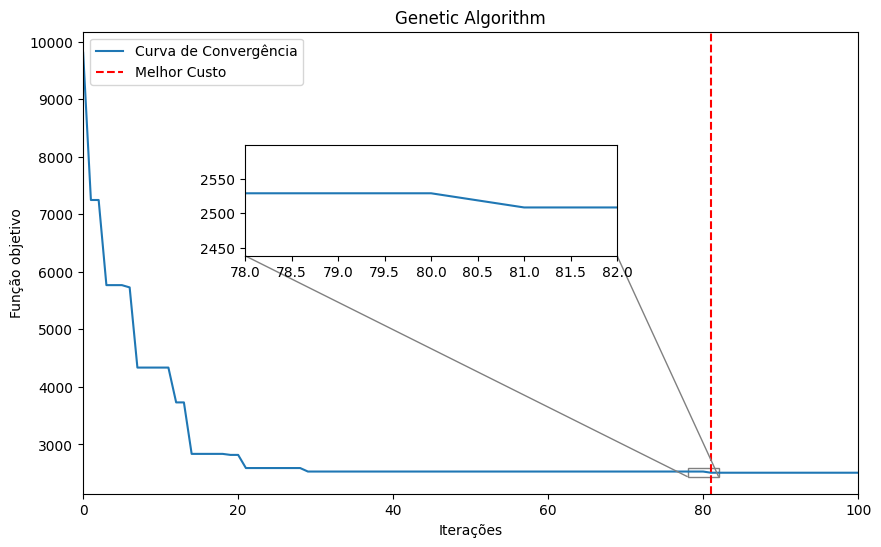


Cenário: primeiro_cenario
Número total de iterações: 100
Tamanho da população: 100
Número de Dimensões: 24
Melhor Custo: R$ 2.508,26
Número de Iterações até o Melhor Custo: 82
Tempo de Convergência para a segunda etapa: 74.24892067909241 segundos


In [621]:
# Plotando a curva de convergência

# Localizando o índice da melhor interação
index_melhor_custo = convergence.index(min(convergence))

# Criar a figura e o eixo principal
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(convergence, label='Curva de Convergência')

# Plotando a linha vertical no gráfico principal
ax.axvline(index_melhor_custo, color='red', linestyle='--', label='Melhor Custo')

# Labels e título
ax.set_xlabel('Iterações')
ax.set_xlim(0, len(convergence) - 1)
ax.set_ylabel('Função objetivo')
ax.set_title('Genetic Algorithm')

# Adicionar a região de zoom
# Definindo a área de interesse para o zoom
x1, x2 = max(0, index_melhor_custo - 3), min(len(convergence) - 1, index_melhor_custo + 1)
y1, y2 = min(convergence[x1:x2]) - 70, max(convergence[x1:x2]) + 70

# Criando o gráfico de zoom (posicionado para não sobrepor a linha de convergência)
axins = zoomed_inset_axes(ax, zoom=12, loc='lower left', bbox_to_anchor=([0.2, 0.5, 0.3, 0.4]), bbox_transform=ax.transAxes)
axins.plot(convergence)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Remover ticks na área de zoom para limpar a visualização
# plt.xticks(visible=False)
# plt.yticks(visible=False)

# Conectar a região de zoom com o gráfico principal
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

# Adicionar legenda
ax.legend()

# Mostrar o gráfico
plt.show()

print("")
print('Cenário:', CENARIO)
print("Número total de iterações:", algorithm_param_['max_num_iteration'])
print("Tamanho da população:", algorithm_param_['population_size'])
print("Número de Dimensões:", dimension)
print("Melhor Custo:", melhorCusto)
print("Número de Iterações até o Melhor Custo:", numero_interacoes)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

In [638]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}_comparacao.csv', sep=";")
dados.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,numero_interacoes
0,1,2508.26,74.248921,82
1,2,2569.89,74.921325,77
2,3,2542.06,75.084465,97
3,4,2633.41,77.293410,90
4,5,2502.65,75.908263,97
5,6,2501.83,76.068714,10
6,7,2502.65,74.363147,41
7,8,2501.76,76.878713,36
8,9,2504.05,77.214069,46
9,10,2559.31,76.158962,61


In [639]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       10 non-null     int64  
 1   Melhor_Custo                10 non-null     float64
 2   Convergencia_Segunda_Etapa  10 non-null     float64
 3   numero_interacoes           10 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 448.0 bytes


In [640]:
dados.describe()

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,numero_interacoes
count,10.00000,10.000000,10.000000,10.0000
mean,5.50000,2532.587000,75.813999,63.7000
std,3.02765,44.039825,1.123425,29.6425
min,1.00000,2501.760000,74.248921,10.0000
25%,3.25000,2502.650000,74.962110,42.2500
50%,5.50000,2506.155000,75.988489,69.0000
75%,7.75000,2554.997500,76.698775,88.0000
max,10.00000,2633.410000,77.293410,97.0000
